This notebook runs a small test of the di-SNE implementation, visualizing a subset of the [Iris Dataset example](https://scikit-learn.org/stable/auto_examples/datasets/plot_iris_dataset.html#sphx-glr-auto-examples-datasets-plot-iris-dataset-py), which can be found at the scikit-learn website. The example dataset is included in this folder as `test_dataset.txt`.

```
# install packages
pip install --user scanpy leidenalg
```

In [20]:
%%bash
pip install --user scanpy harmonypy leidenalg

  Using cached harmonypy-0.0.9-py3-none-any.whl (20 kB)
  Using cached leidenalg-0.10.2-cp38-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (2.0 MB)
  Using cached igraph-0.11.5-cp39-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (3.3 MB)
  Using cached texttable-1.7.0-py2.py3-none-any.whl (10 kB)


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [21]:
# set up packages to cluster data
import sys
import os
sys.path.append(os.environ["HOME"]+"/.local/lib/python3.9/site-packages")

In [22]:
import scanpy as sc, anndata as ad
import numpy as np
import harmonypy
import leidenalg
import pandas as pd
from sklearn.datasets import make_blobs
from scipy.sparse import issparse

In [23]:
# diSNE packages 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.spatial.distance import pdist, squareform

In [24]:
# check imports
sc.logging.print_versions()

-----
anndata     0.9.1
scanpy      1.9.3
-----
PIL                 8.3.1
anyio               NA
attr                21.2.0
babel               2.9.1
backcall            0.2.0
beta_ufunc          NA
binom_ufunc         NA
bottleneck          1.3.2
brotli              NA
certifi             2022.12.07
cffi                1.14.6
chardet             4.0.0
charset_normalizer  2.0.0
cloudpickle         1.6.0
colorama            0.4.6
cycler              0.10.0
cython_runtime      NA
cytoolz             0.11.0
dask                2021.06.2
dateutil            2.8.2
debugpy             1.6.7
decorator           5.0.9
defusedxml          0.7.1
entrypoints         0.3
fastjsonschema      NA
fsspec              2021.07.0
google              NA
h5py                3.3.0
harmonypy           NA
idna                3.1
igraph              0.11.5
ipykernel           6.17.1
ipython_genutils    0.2.0
ipywidgets          7.6.3
jedi                0.18.0
jinja2              3.0.1
joblib              1.0.

In [25]:
DATADIR=os.environ["HOME"]+"/public/lab6" #defining dir path
dataset = sc.read_10x_mtx(DATADIR, prefix="GSM5114461_S6_A11_", cache=True)

In [26]:
DATADIR=os.environ["HOME"]+"/public/lab6"
dsets = ["GSM5114461_S6_A11", "GSM5114464_S7_D20", "GSM5114474_M3_E7"]
adatas = {}
for ds in dsets:
    print(ds)
    adatas[ds] = sc.read_10x_mtx(DATADIR, prefix=ds+"_", cache=True)
combined = ad.concat(adatas, label="dataset")
combined.obs_names_make_unique()

GSM5114461_S6_A11
GSM5114464_S7_D20
GSM5114474_M3_E7


/opt/conda/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [27]:
combined.obs 

,dataset
AAACCTGAGAAGGACA,GSM5114461_S6_A11
AAACCTGAGTAAGTAC,GSM5114461_S6_A11
AAACCTGGTCCCGACA,GSM5114461_S6_A11
AAACCTGTCCTAAGTG,GSM5114461_S6_A11
AAACCTGTCGCCTGTT,GSM5114461_S6_A11
...,...
TTTGTCAAGCGTCTAT,GSM5114474_M3_E7
TTTGTCAAGTCGTACT,GSM5114474_M3_E7
TTTGTCAGTCTGATTG,GSM5114474_M3_E7
TTTGTCATCCCGGATG,GSM5114474_M3_E7


In [28]:
# Filter cells by minimum number of genes
sc.pp.filter_cells(combined, min_genes=200)

# Filter cells by minimum counts
sc.pp.filter_cells(combined, min_counts=1000)

# Filter genes by minimum counts
sc.pp.filter_genes(combined, min_counts=15)

# Filter genes by minimum cells
sc.pp.filter_genes(combined, min_cells=5)

In [29]:
combined.var["mt"] = combined.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(
    combined, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True
)

In [30]:
combined_filt = combined[combined.obs.n_genes_by_counts < 8000, :]
combined_filt =combined_filt[combined_filt.obs.pct_counts_mt < 25, :].copy()

In [31]:
sc.pp.normalize_per_cell(combined_filt, counts_per_cell_after=1e4) # normalize to 10,000 reads/cell
sc.pp.log1p(combined_filt) # log transform

In [32]:
sc.pp.highly_variable_genes(combined_filt,batch_key="dataset",n_top_genes=500)

In [33]:
genes = ["GCG", "TTR",  "IAPP",  "GHRL", "PPY", "COL3A1",
    "CPA1", "CLPS", "REG1A", "CTRB1", "CTRB2", "PRSS2", "CPA2", "KRT19", "INS","SST","CELA3A", "VTCN1"]

combined_var = combined_filt[:, (combined_filt.var.index.isin(genes) | combined_filt.var["highly_variable"])]

In [34]:
sc.pp.pca(combined_var,n_comps=20)

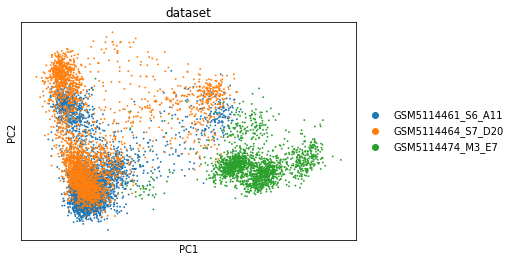

In [35]:
sc.pl.pca(combined_var,color='dataset')

In [36]:
# Import the "external" library
import scanpy.external as sce

# Run harmony using suggested params from the paper
sce.pp.harmony_integrate(combined_var, 'dataset', theta=2, nclust=50,  max_iter_harmony = 10,  max_iter_kmeans=10)

# Reset the original PCs to those computed by Harmony
combined_var.obsm['X_pca'] = combined_var.obsm['X_pca_harmony']

2024-05-21 22:14:07,530 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
Computing initial centroids with sklearn.KMeans...
2024-05-21 22:14:10,905 - harmonypy - INFO - sklearn.KMeans initialization complete.
sklearn.KMeans initialization complete.
2024-05-21 22:14:10,974 - harmonypy - INFO - Iteration 1 of 10
Iteration 1 of 10
2024-05-21 22:14:13,974 - harmonypy - INFO - Iteration 2 of 10
Iteration 2 of 10
2024-05-21 22:14:17,773 - harmonypy - INFO - Iteration 3 of 10
Iteration 3 of 10
2024-05-21 22:14:21,171 - harmonypy - INFO - Iteration 4 of 10
Iteration 4 of 10
2024-05-21 22:14:24,470 - harmonypy - INFO - Iteration 5 of 10
Iteration 5 of 10
2024-05-21 22:14:27,457 - harmonypy - INFO - Iteration 6 of 10
Iteration 6 of 10
2024-05-21 22:14:31,265 - harmonypy - INFO - Iteration 7 of 10
Iteration 7 of 10
2024-05-21 22:14:34,967 - harmonypy - INFO - Converged after 7 iterations
Converged after 7 iterations


In [37]:
sc.pp.neighbors(combined_var) # computes neighborhood graphs. Needed to run clustering.
sc.tl.leiden(combined_var)

In [38]:
# TEST: use diSNE to run t-SNE and visualize clusters
# Step 1: Compute pairwise distances
def pairwise_distances(X):
    if issparse(X):
        X = X.toarray() 
    return squareform(pdist(X, 'euclidean'))

# Step 2: Compute joint probabilities P in high-dimensional space
def compute_joint_probabilities(distances, perplexity=30.0):
    (n, _) = distances.shape
    P = np.zeros((n, n))
    beta = np.ones((n, 1))
    logU = np.log(perplexity)
    
    for i in range(n):
        betamin = -np.inf
        betamax = np.inf
        Di = distances[i, np.concatenate((np.r_[0:i], np.r_[i+1:n]))]
        H, thisP = Hbeta(Di, beta[i])
        
        Hdiff = H - logU
        tries = 0
        while np.abs(Hdiff) > 1e-5 and tries < 50:
            if Hdiff > 0:
                betamin = beta[i].copy()
                if betamax == np.inf:
                    beta[i] *= 2
                else:
                    beta[i] = (beta[i] + betamax) / 2
            else:
                betamax = beta[i].copy()
                if betamin == -np.inf:
                    beta[i] /= 2
                else:
                    beta[i] = (beta[i] + betamin) / 2
            
            H, thisP = Hbeta(Di, beta[i])
            Hdiff = H - logU
            tries += 1
        
        P[i, np.concatenate((np.r_[0:i], np.r_[i+1:n]))] = thisP
    
    P = P + np.transpose(P)
    P = P / np.sum(P)
    P = np.maximum(P, 1e-12)
    return P

def Hbeta(D, beta):
    P = np.exp(-D * beta)
    sumP = np.sum(P)
    H = np.log(sumP) + beta * np.sum(D * P) / sumP
    P = P / sumP
    return H, P

# Step 3: Initialize embedding Y
def initialize_embedding(n, dim=2):
    return np.random.randn(n, dim)

# Step 4: Compute low-dimensional affinities Q
def compute_low_dim_affinities(Y):
    distances = pairwise_distances(Y)
    inv_distances = 1 / (1 + distances)
    np.fill_diagonal(inv_distances, 0)
    inv_distances_sum = np.sum(inv_distances)
    Q = inv_distances / (inv_distances_sum + 1e-12)  # Add epsilon to avoid division by zero
    Q = np.maximum(Q, 1e-12)
    return Q

# Step 5: Compute gradients and update embedding
def compute_gradients(P, Q, Y):
    n, dim = Y.shape
    dY = np.zeros((n, dim))
    PQ_diff = P - Q
    for i in range(n):
        dY[i, :] = 4 * np.sum((PQ_diff[:, i].reshape(-1, 1) * (Y[i, :] - Y)), axis=0)
    return dY

def update_embedding(Y, dY, learning_rate=200.0):
    # Normalize the gradients
    grad_norm = np.linalg.norm(dY, axis=1, keepdims=True)
    dY = dY / (grad_norm + 1e-12)
    
    # Clip the gradients to prevent excessively large updates
    max_step_size = 1.0
    dY = np.clip(dY, -max_step_size, max_step_size)
    
    return Y - learning_rate * dY

# Step 6: The main t-SNE function modified to store results in adata.obsm['X_tsne']
def tsne(adata, perplexity=30.0, n_iter=1000, learning_rate=10.0):
    X = adata.X
    distances = pairwise_distances(X)
    P = compute_joint_probabilities(distances, perplexity)
    Y = initialize_embedding(X.shape[0])
    
    for iter in range(n_iter):
        Q = compute_low_dim_affinities(Y)
        dY = compute_gradients(P, Q, Y)
        Y = update_embedding(Y, dY, learning_rate)
        
        if iter % 100 == 0:
            cost = np.sum(P * np.log(P / Q))
            # Uncomment the next line if you want to see the progress
            print(f"Iteration {iter}: cost = {cost}")
            pass
    
    # Store the resulting t-SNE embedding in adata.obsm['X_tsne']
    adata.obsm['X_tsne'] = Y

In [ ]:
tsne(combined_var) #Running tsne

In [32]:
def plot_tsne_results(adata, feature, title='t-SNE results', figsize=(10, 8)):
    tsne_out = adata.obsm['X_tsne']
    labels = adata.obs[feature].astype(int).values
    plt.figure(figsize=figsize)
    scatter = plt.scatter(tsne_out[:, 0], tsne_out[:, 1], c=labels, cmap='viridis', marker='o')
    if labels is not None:
        plt.legend(*scatter.legend_elements(), title="Clusters")
    plt.title(title)
    plt.xlabel('t-SNE 1')
    plt.ylabel('t-SNE 2')
    plt.colorbar()
    plt.show()

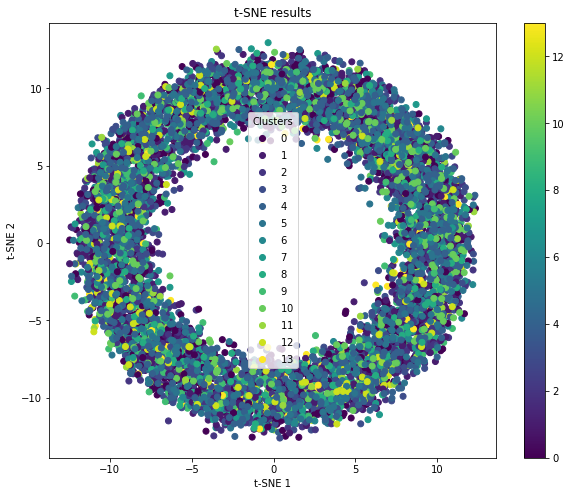

In [34]:
# Extract t-SNE results and cluster labels
#tsne_out = adata.obsm['X_tsne']
#clusters = adata.obs['leiden'].astype(int).values  # Cluster labels

# Plot the t-SNE results
plot_tsne_results(combined_var, feature='leiden')